File name: main.ipynb

Author: ADAMsLEG

Date created: 03/11/2022

Date last modified: 03/11/2022

Python Version: 3.9


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "data/"

INTERVENTIONS_DATASET = DATA_PATH + "interventions.csv"
GLOBAL_MOBILITY_DATASET = DATA_PATH + "Global_Mobility_Report.csv.gz"
TOPICS_LINKED_DATASET = DATA_PATH + "topics_linked.csv.xz"
AGGREGATED_JSON = DATA_PATH + "aggregated_timeseries.json.gz"
COVIDISTRESS_APRIL = DATA_PATH + "COVIDISTRESS_april_cleaned.csv"
COVIDISTRESS_MAI = DATA_PATH + "COVIDISTRESS_mai_cleaned.csv"
COVIDISTRESS_JUNE = DATA_PATH + "COVIDISTRESS_june_cleaned.csv"

In [3]:
df_interventions = pd.read_csv(INTERVENTIONS_DATASET)
df_interventions.head()

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29


In [4]:
df_global = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip')
df_global.head()

C:\Users\josan\AppData\Local\Temp\ipykernel_2304\3108490629.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_global = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip')


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [5]:
df_topics = pd.read_csv(TOPICS_LINKED_DATASET, compression='xz')
df_topics.head()

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
0,Rosmalen,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2001490
1,Commelinales,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q290349
2,Transport_in_Honduras,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q1130638
3,QuakeC,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2122062
4,Food_writing,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q5465542


In [6]:
ts_aggregated = pd.read_json(AGGREGATED_JSON, compression='gzip')
ts_aggregated.head()

,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,ko.m,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko
len,1197788,1594039,256451,346007,516838,6047509,632128,345790,6045654,531478,...,489181,480638,396063,1197856,2195949,481854,642031,1588312,1959446,490314
sum,"{'2018-01-01 00:00:00': 22328288, '2018-01-02 ...","{'2018-01-01 00:00:00': 3338750, '2018-01-02 0...","{'2018-01-01 00:00:00': 765123, '2018-01-02 00...","{'2018-01-01 00:00:00': 407629, '2018-01-02 00...","{'2018-01-01 00:00:00': 715031, '2018-01-02 00...","{'2018-01-01 00:00:00': 86763830, '2018-01-02 ...","{'2018-01-01 00:00:00': 192409, '2018-01-02 00...","{'2018-01-01 00:00:00': 493684, '2018-01-02 00...","{'2018-01-01 00:00:00': 135822131, '2018-01-02...","{'2018-01-01 00:00:00': 224417, '2018-01-02 00...",...,"{'2018-01-01 00:00:00': 1484496, '2018-01-02 0...","{'2018-01-01 00:00:00': 1319053, '2018-01-02 0...","{'2018-01-01 00:00:00': 451383, '2018-01-02 00...","{'2018-01-01 00:00:00': 7828155, '2018-01-02 0...","{'2018-01-01 00:00:00': 6441009, '2018-01-02 0...","{'2018-01-01 00:00:00': 523135, '2018-01-02 00...","{'2018-01-01 00:00:00': 111910, '2018-01-02 00...","{'2018-01-01 00:00:00': 12856884, '2018-01-02 ...","{'2018-01-01 00:00:00': 2383474, '2018-01-02 0...","{'2018-01-01 00:00:00': 819174, '2018-01-02 00..."
covid,"{'len': 30, 'sum': {'2018-01-01 00:00:00': 55,...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 50,...","{'len': 4, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 1, ...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 7, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 57...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 6, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 3, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 91...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 2, ...",...,"{'len': 113, 'sum': {'2018-01-01 00:00:00': 6,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 11, ...","{'len': 30, 'sum': {'2018-01-01 00:00:00': 26,...","{'len': 16, 'sum': {'2018-01-01 00:00:00': 62,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 2, '...","{'len': 49, 'sum': {'2018-01-01 00:00:00': 6, ...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 139...","{'len': 8, 'sum': {'2018-01-01 00:00:00': 19, ...","{'len': 113, 'sum': {'2018-01-01 00:00:00': 3,..."
topics,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 29427...,{'Culture.Biography.Biography*': {'len': 57720...,{'Culture.Biography.Biography*': {'len': 70443...,{'Culture.Biography.Biography*': {'len': 11603...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 37718...,{'Culture.Biography.Biography*': {'len': 70434...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 11804...,...,{'Culture.Biography.Biography*': {'len': 75406...,{'Culture.Biography.Biography*': {'len': 10422...,{'Culture.Biography.Biography*': {'len': 37580...,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 38258...,{'Culture.Biography.Biography*': {'len': 10444...,{'Culture.Biography.Biography*': {'len': 10175...,{'Culture.Biography.Biography*': {'len': 29422...,{'Culture.Biography.Biography*': {'len': 14668...,{'Culture.Biography.Biography*': {'len': 75498...


In [7]:
df_anxiety_keyword = df_topics.loc[df_topics['index'].str.contains('anxiety').fillna(False)]
df_anxiety_keyword.head(5) #Social_anxiety is in the STEM.Medicine & Health topic,  

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
29745,Social_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q3557657
100264,Intergroup_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q6046586
637466,Preoperational_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q7240583
805017,Library_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q6542544
853325,Separation_anxiety_in_dogs,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q7451812


In [8]:
import json
import gzip
data = [] #dict
with gzip.open(AGGREGATED_JSON, 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))

STEM_medicineandhealth = data["en"]["topics"]["STEM.Medicine & Health"] #more example on how to use in dataset description excel doc
pd.DataFrame.from_dict(STEM_medicineandhealth)

,len,sum,percent
2018-01-01 00:00:00,63878,2207035,0.011472
2018-01-02 00:00:00,63878,3360222,0.012693
2018-01-03 00:00:00,63878,3648640,0.012824
2018-01-04 00:00:00,63878,3541603,0.013144
2018-01-05 00:00:00,63878,3357763,0.012822
...,...,...,...
2020-07-27 00:00:00,63878,2426547,0.011131
2020-07-28 00:00:00,63878,2442731,0.011610
2020-07-29 00:00:00,63878,2487592,0.012039
2020-07-30 00:00:00,63878,2297755,0.011380


### COVIDiSTRESS visualization

In [9]:
df_covidistress_april = pd.read_csv(COVIDISTRESS_APRIL)
df_covidistress_april.head(3)

,Unnamed: 0.1,Unnamed: 0,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,Dem_employment,...,Expl_media_6,Final_open,PSS10_avg,SLON3_avg,neu,ext,ope,agr,con,SPS_avg
0,0,1,1058,2020-04-27 04:20:30,DA,33,Female,"College degree, bachelor, master",Some College or equivalent,Full time employed,...,3.0,NaN,1.6,2.333333,2.000000,5.000000,4.666667,4.000000,3.666667,6.000000
1,1,2,1323,2020-04-27 04:17:16,NL,52,Male,"College degree, bachelor, master",Up to 12 years of school,Self-employed,...,4.0,Ik ben blij met de 'intelligente lockdown' zoa...,2.5,3.000000,4.666667,3.666667,5.000000,4.333333,4.666667,4.400000
2,2,3,801,2020-04-27 04:05:14,SK,52,Female,"College degree, bachelor, master",College degree,Full time employed,...,4.0,NaN,2.4,3.666667,3.000000,4.333333,4.333333,5.000000,4.666667,5.222222


In [10]:
df_covidistress_mai = pd.read_csv(COVIDISTRESS_MAI)
df_covidistress_mai.head(3)

C:\Users\josan\AppData\Local\Temp\ipykernel_2304\1816487094.py:1: DtypeWarning: Columns (56,57,58,59,60,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_covidistress_mai = pd.read_csv(COVIDISTRESS_MAI)


,Unnamed: 0,ID,answered_all,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,...,Final_open,PSS10_avg,SLON3_avg,neu,ext,ope,agr,con,SPS_avg,Scale_UCLA_TRI_avg
0,3,4,No,1710,2020-05-29 22:47:17,BG,79,Male,"College degree, bachelor, master",College degree,...,NaN,3.6,4.000000,4.000000,4.666667,4.000000,5.000000,5.000000,3.9,NaN
1,5,6,Yes,1221,2020-05-29 21:25:09,IT,68,Male,"College degree, bachelor, master",College degree,...,NaN,2.1,2.333333,3.333333,3.666667,4.333333,4.000000,3.666667,5.0,NaN
2,22,23,Yes,1004,2020-05-29 18:03:27,FR,28,Female,PhD/Doctorate,Up to 9 years of school,...,NaN,2.8,2.333333,4.666667,4.000000,5.333333,4.666667,3.333333,5.0,NaN


In [11]:
df_covidistress_june = pd.read_csv(COVIDISTRESS_JUNE)
df_covidistress_june.head(3)

C:\Users\josan\AppData\Local\Temp\ipykernel_2304\883657938.py:1: DtypeWarning: Columns (55,56,57,58,59,60,61,66,67,68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df_covidistress_june = pd.read_csv(COVIDISTRESS_JUNE)


,Unnamed: 0.1,Unnamed: 0,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,Dem_employment,...,Final_open,PSS10_avg,SLON3_avg,neu,ext,ope,agr,con,SPS_avg,Scale_UCLA_TRI_avg
0,0,1,777,2020-06-17 01:01:39,NL,48,Female,"College degree, bachelor, master",NaN,Full time employed,...,Reguliere ziekenhuiszorg is verminderd: mijn c...,2.4,2.666667,4.000000,3.666667,4.666667,4.333333,5.000000,5.1,NaN
1,1,2,952,2020-06-16 23:19:18,PL,36,Female,"College degree, bachelor, master",Up to 12 years of school,Full time employed,...,NaN,1.7,1.000000,2.333333,3.666667,3.000000,3.666667,4.666667,5.3,NaN
2,2,3,2396,2020-06-16 22:47:36,EN,45,Female,"College degree, bachelor, master",Up to 12 years of school,Full time employed,...,NaN,1.7,2.000000,2.666667,4.333333,5.000000,5.000000,5.000000,5.2,NaN


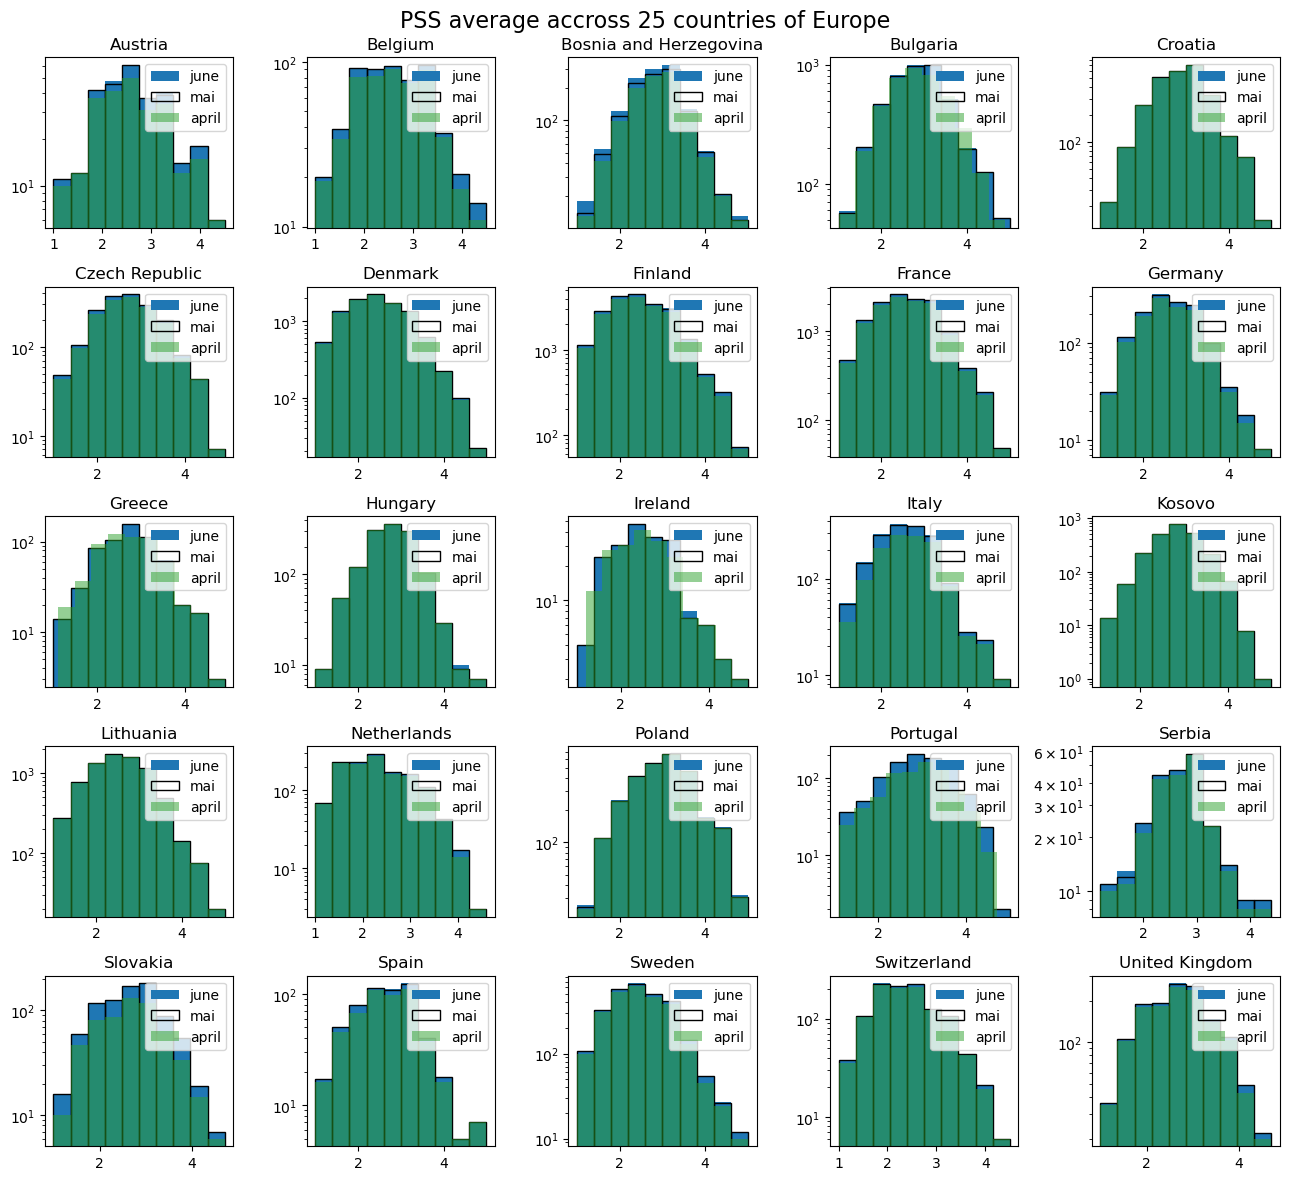

In [109]:
MONTHS = ['june', 'mai', 'april']

fig, ax = plt.subplots(5, 5, figsize=(13, 12))

axes = ax.flatten()
for country, axe in zip(june_country.index, axes):
    df_hist_june = df_covidistress_june.loc[df_covidistress_june['Country'] == country]
    df_hist_mai = df_covidistress_mai.loc[df_covidistress_mai['Country'] == country]
    df_hist_april = df_covidistress_april.loc[df_covidistress_april['Country'] == country]
    
    axe.hist(df_hist_june['PSS10_avg'][:])
    axe.hist(df_hist_mai['PSS10_avg'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['PSS10_avg'][:], alpha = .5)
    axe.set_yscale('log')
    axe.set_title(country)
    axe.legend(MONTHS)

fig.suptitle('PSS average accross 25 countries of Europe', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

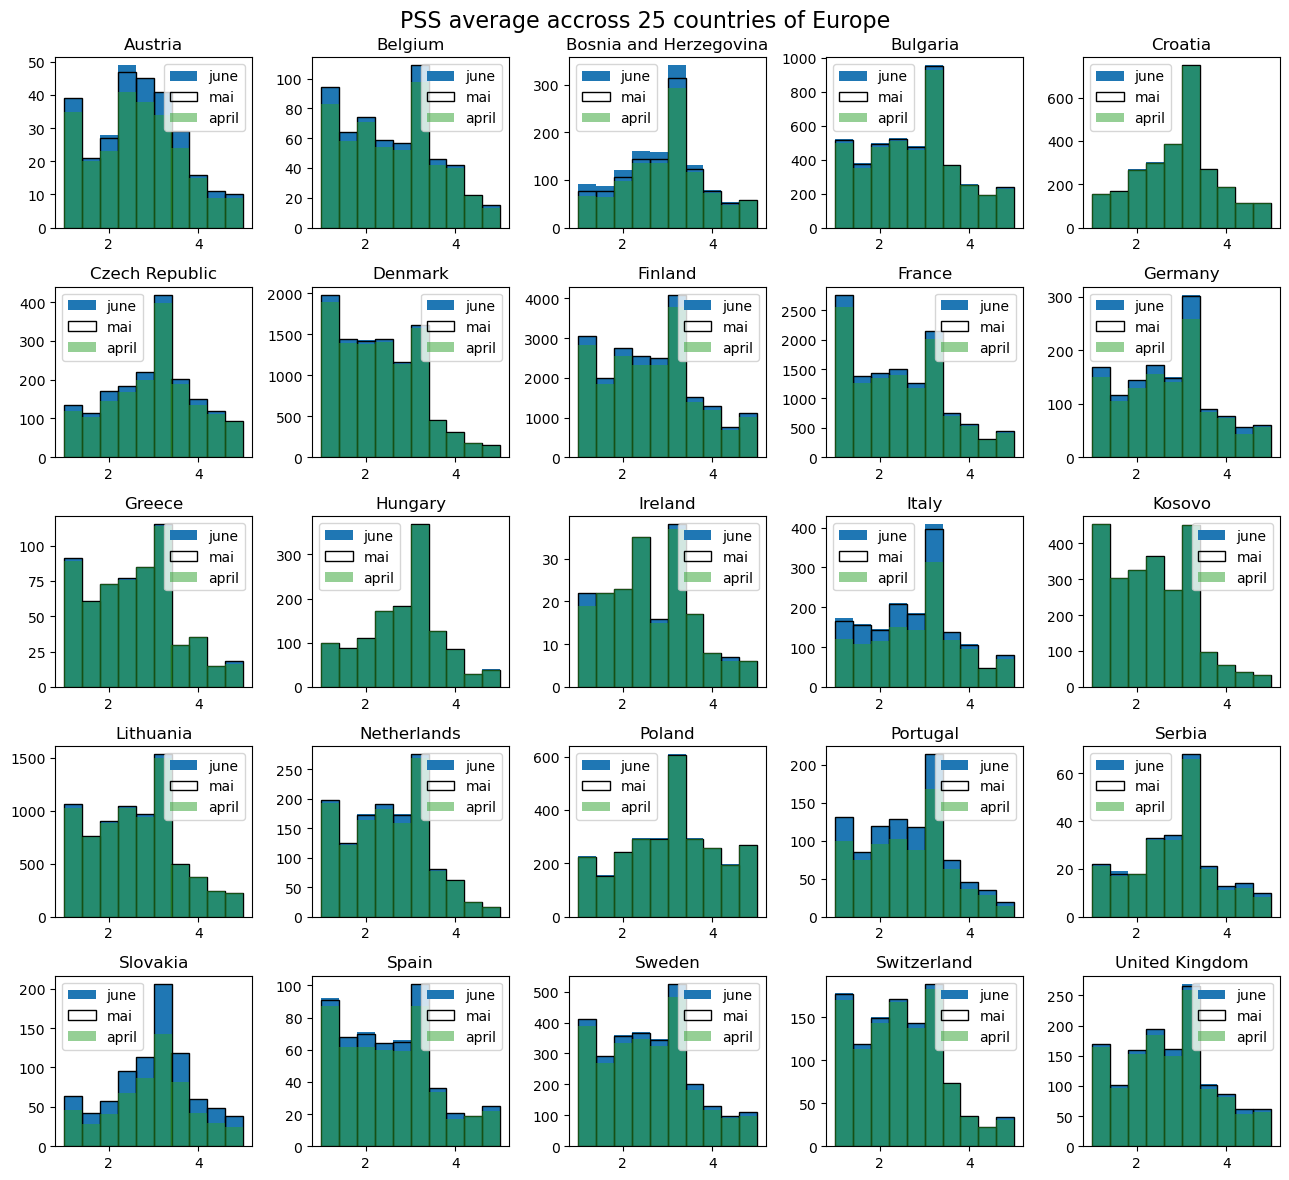

In [108]:
fig, ax = plt.subplots(5, 5, figsize=(13, 12))

axes = ax.flatten()
for country, axe in zip(june_country.index, axes):
    df_hist_june = df_covidistress_june.loc[df_covidistress_june['Country'] == country]
    df_hist_mai = df_covidistress_mai.loc[df_covidistress_mai['Country'] == country]
    df_hist_april = df_covidistress_april.loc[df_covidistress_april['Country'] == country]
    
    axe.hist(df_hist_june['SLON3_avg'][:])
    axe.hist(df_hist_mai['SLON3_avg'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['SLON3_avg'][:], alpha = .5)
    #axe.set_yscale('log')
    axe.set_title(country)
    axe.legend(MONTHS)

fig.suptitle('PSS average accross 25 countries of Europe', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.94)